In [195]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (validation_images, validation_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [120]:
mnist = tf.keras.datasets.mnist
(train_images2, train_labels2), (validation_images2, validation_labels2) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [125]:
#normalizacion de datos
media = np.mean(train_images,axis=0)
desvio = np.std(train_images,axis=0)
train_images = (train_images - media)/desvio
numero_muestras = train_images.shape[0] 
area_imagen = train_images.shape[1]*train_images.shape[2] 

validation_images = (validation_images - media)/desvio

validation_images2 = (validation_images2 - media)/desvio

In [4]:
unidades_ocultas = 150
num_epochs = 1000
numero_muestras =train_labels.shape[0]
#autoencoder
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(28,28)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(unidades_ocultas, activation='relu', kernel_initializer='HeNormal'))
model.add(tf.keras.layers.Dense(area_imagen,kernel_initializer='HeNormal'))
model.add(tf.keras.layers.Reshape((28, 28), input_shape=(area_imagen,)))
model.summary()
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5) 
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='MeanSquaredError')
hist = model.fit(x=train_images, y=train_images, batch_size = numero_muestras, epochs=num_epochs, callbacks = [es],validation_data=(validation_images,validation_images))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 150)               117750    
                                                                 
 dense_1 (Dense)             (None, 784)               118384    
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 236,134
Trainable params: 236,134
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1/1 [==============================] - 4s 4s/step - loss: 2.9133 - val_loss: 2.4399
Epoch 2/1000
1/1 [==============================] - 0s 273ms/step - loss: 2.3995 - va

In [6]:
ecm = hist.history['val_loss'][np.shape(hist.history['val_loss'])[0]-1]
print("Error cuadratico medio de validacion:", ecm)

Error cuadratico medio de validacion: 0.17365038394927979


In [113]:
def cuadratic_error(dataset, dataset2):
  umbral = np.array([]) #arrays de errores cuadraticos
  for x in np.arange(np.shape(dataset)[0]):
      a = dataset[x,:,:].reshape(1, 28*28)
      b = dataset2[x,:,:].reshape(1,28*28)
      ec = np.sum((a-b)**2)
      umbral = np.append(umbral, ec)
  return umbral

In [181]:
#nuevo
new_dataset = np.vstack((validation_images, validation_images2))
new_dataset_labels = np.hstack((validation_labels, validation_labels2))
predicted_dataset = model.predict(new_dataset)
#vector de umbrales en base a su error cuadratico
ce_vector = cuadratic_error(new_dataset, predicted_dataset)


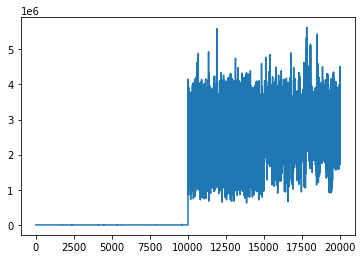

In [182]:
plt.plot(ce_vector)

In [170]:
tp2 = np.sum(ce_vector[:10000]<25)
print(tp2)

47


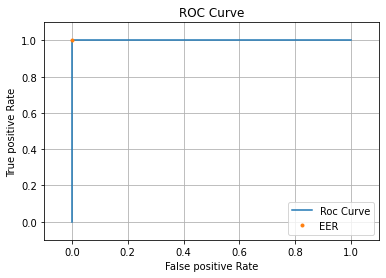

In [186]:
cant_puntos = 1000
umbral = np.linspace(np.min(ce_vector), np.max(ce_vector),cant_puntos)
tp = np.zeros(cant_puntos)
fn = np.zeros(cant_puntos)
tn = np.zeros(cant_puntos)
fp = np.zeros(cant_puntos)
for (idx,t) in enumerate(umbral):
  tp[idx] = np.sum(ce_vector[:10000]<t)
  fn[idx] = np.sum(ce_vector[:10000]>t)
  tn[idx] = np.sum(ce_vector[10000:]>t)
  fp[idx] = np.sum(ce_vector[10000:]<t)

tpr = tp/(tp+fn)
fpr = fp/(fp+tn)
ce_vector2 = (tpr-fpr)**2
#eer = 
plt.title("ROC Curve")
plt.xlabel("False positive Rate")
plt.ylabel("True positive Rate")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.plot(fpr, tpr, label= 'Roc Curve')
plt.plot(0,1,'.' ,label = "EER")
plt.grid()
plt.legend()

In [187]:
#nueva base de datos

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Input(shape=(28,28)))
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(unidades_ocultas, activation='relu', kernel_initializer='HeNormal'))
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_7 (Dense)             (None, 150)               117750    
                                                                 
Total params: 117,750
Trainable params: 117,750
Non-trainable params: 0
_________________________________________________________________


In [189]:
model2.set_weights(model.layers[1].get_weights())
dataset3 = np.vstack((train_images, validation_images))
predict3 = model2.predict(dataset3)

In [193]:
#guardo modelos y pesos 
from keras.models import model_from_json
model_json = model.to_json()
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)
#serializan los pesos (weights) para HDF5
model.save_weights("model.h5")
print("Modelo guardado en el PC")


Modelo guardado en el PC


In [198]:
#guardo dataframes
df = pd.DataFrame(predict3)
df.to_csv('dataframes.csv', index=False)